In [ ]:
!pip install pytket

!pip install qiskit

!pip install pytket-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute

from tqdm import tqdm
from typing import Optional, Union
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.random import random_unitary
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.generalized_gates.permutation import Permutation

In [ ]:
def create_states_new(num_qubit):
    """Create states for the evolution."""
    out = np.empty(2**num_qubit,dtype='complex')
    for i in range(2**num_qubit):
        out[i] = np.array(np.random.uniform(-1, 1, 1) + 1.j * np.random.uniform(-1, 1, 1))

    out = out/np.sqrt(np.sum(np.abs(out)**2))
    return out

In [ ]:
class QuantumVolume(QuantumCircuit):
    """A quantum volume model circuit.

    The model circuits are random instances of circuits used to measure
    the Quantum Volume metric, as introduced in [1].
    """

    def __init__(
        self,
        num_qubits: int,
        depth: Optional[int] = None,
        seed: Optional[Union[int, np.random.Generator]] = None,
        classical_permutation: bool = True,
    ) -> None:
        """Create quantum volume model circuit of size num_qubits x depth
        """
        # Initialize RNG
        if seed is None:
            rng_set = np.random.default_rng()
            seed = rng_set.integers(low=1, high=1000)
        if isinstance(seed, np.random.Generator):
            rng = seed
        else:
            rng = np.random.default_rng(seed)

        # Parameters
        depth = depth or num_qubits  # how many layers of SU(4)
        width = int(np.floor(num_qubits / 2))  # how many SU(4)s fit in each layer
        name = "quantum_volume_" + str([num_qubits, depth, seed]).replace(" ", "")

        # Generator random unitary seeds in advance.
        unitary_seeds = rng.integers(low=1, high=1000, size=[depth, width])
        indices_of_gates = np.empty((depth,width,2))
        self.indices_of_gates = indices_of_gates
        # For each layer, generate a permutation of qubits
        # Then generate and apply a Haar-random SU(4) to each pair
        circuit = QuantumCircuit(num_qubits, name=name)
        self.circuit = circuit

        #circuit.initialize(create_states_new(num_qubits),circuit.qubits)
        circuit.initialize('0'*num_qubits)
        perm_0 = list(range(num_qubits))
        for d in range(depth):
            perm = rng.permutation(perm_0)
            if not classical_permutation:
                layer_perm = Permutation(num_qubits, perm)
                circuit.compose(layer_perm, inplace=True)
            for w in range(width):
                seed_u = unitary_seeds[d][w]
                su4 = random_unitary(4, seed=seed_u).to_instruction()
                su4.label = "su4_" + str(seed_u)
                if classical_permutation:
                    physical_qubits = int(perm[2 * w]), int(perm[2 * w + 1])
                    indices_of_gates[d][w] = physical_qubits
                    circuit.compose(su4, [physical_qubits[0], physical_qubits[1]], inplace=True)
                else:
                    circuit.compose(su4, [2 * w, 2 * w + 1], inplace=True)

        super().__init__(*circuit.qregs, name=circuit.name)
        self.compose(circuit.to_instruction(), qubits=self.qubits, inplace=True)

In [ ]:
num_qubits = 4
width = int(np.floor(num_qubits / 2))
depth = 4
num_initial_states = 2**num_qubits
num_circuits = 1000
all_probs = np.empty((num_circuits,2**num_qubits))

QV = QuantumVolume(num_qubits, depth=depth)
backend = Aer.get_backend('statevector_simulator')
result = execute(QV.circuit, backend, shots=1000).result()
statevector = result.get_statevector(QV.circuit)
print(QV.indices_of_gates)
all_gates = QV.indices_of_gates
swaps = 0
for hey in np.reshape(all_gates,(depth*width,2)):
    swaps += 2*(np.abs(hey[0]-hey[1]) - 1)

QV.circuit.draw()

[[[1. 0.]
  [2. 3.]]

 [[1. 2.]
  [3. 0.]]

 [[1. 3.]
  [2. 0.]]

 [[1. 2.]
  [0. 3.]]]


┌──────────────────────┐┌──────────┐            ┌──────────┐            »
q_0: ┤0                     ├┤1         ├────────────┤1         ├────────────»
     │                      ││  su4_619 │┌──────────┐│          │┌──────────┐»
q_1: ┤1                     ├┤0         ├┤0         ├┤          ├┤0         ├»
     │  Initialize(0,0,0,0) │├──────────┤│  su4_331 ││  su4_998 ││          │»
q_2: ┤2                     ├┤0         ├┤1         ├┤          ├┤  su4_448 ├»
     │                      ││  su4_379 │└──────────┘│          ││          │»
q_3: ┤3                     ├┤1         ├────────────┤0         ├┤1         ├»
     └──────────────────────┘└──────────┘            └──────────┘└──────────┘»
«     ┌──────────┐            ┌──────────┐
«q_0: ┤1         ├────────────┤0         ├
«     │          │┌──────────┐│          │
«q_1: ┤  su4_970 ├┤0         ├┤          ├
«     │          ││  su4_399 ││  su4_621 │
«q_2: ┤0         ├┤1         ├┤          ├
«     └──────────┘└──────────┘│          │
«q_3: ────────────────────────┤1         ├
«                             └──────────┘

In [ ]:
num_qubits = 5
width = int(np.floor(num_qubits / 2))
depth = 5
num_initial_states = 2**num_qubits
num_circuits = 5000
all_probs = np.empty((num_circuits,2**num_qubits))
all_swaps = np.empty(num_circuits)

for i in tqdm(range(num_circuits)):
    QV = QuantumVolume(num_qubits, depth=depth)
    backend = Aer.get_backend('statevector_simulator')
    result = execute(QV.circuit, backend, shots=1000).result()
    all_gates = QV.indices_of_gates
    swaps = 0
    for hey in np.reshape(all_gates,(depth*width,2)):
        swaps += 2*(np.abs(hey[0]-hey[1]) - 1)
    all_swaps[i] = swaps
    statevector = result.get_statevector(QV.circuit)
    #print(np.abs(np.array(statevector))**2)
    prob = np.abs(np.array(statevector))**2
    all_probs[i] = prob

probs = all_probs.mean(axis=0)
print(all_probs.flatten(),all_probs.flatten().shape)

100%|██████████| 5000/5000 [05:09<00:00, 16.15it/s]

[1.12843189e-02 5.18980744e-02 1.42012769e-02 ... 5.21300797e-03
 5.23739534e-04 9.12382733e-05] (160000,)


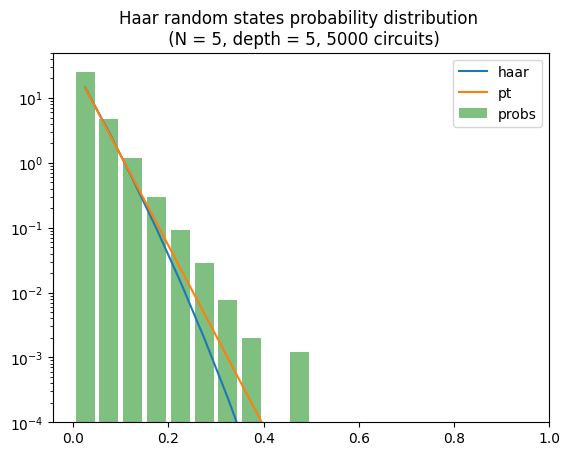

In [ ]:
xplot = np.arange(0,1,0.05)
hist,bin_edges = np.histogram(all_probs.flatten(), bins = xplot)
bin_centers = np.array((bin_edges[:-1] + bin_edges[1:])/2)
plt.bar(bin_centers, hist/num_circuits, width = 0.04, color = 'g', alpha = 0.5, label='probs')
Haar_measure = (2**num_qubits -1)*(1-bin_centers)**(2**num_qubits -2)
pt_measure = 2**num_qubits*np.exp(-bin_centers*2**num_qubits)
plt.plot(bin_centers, Haar_measure, label='haar')
plt.plot(bin_centers,pt_measure, label='pt')
plt.yscale('log')
plt.ylim(1e-4, 5e1)
plt.xlim(None,1)
plt.title(f'Haar random states probability distribution \n (N = {num_qubits}, depth = {depth}, {num_circuits} circuits)')
plt.legend()